# 데이터 불러오기

In [ ]:
!pip install tslearn

In [ ]:
import pandas as pd
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
%matplotlib inline
# 한글 폰트 사용을 위해서 세팅
plt.rcParams['font.family'] ='Malgun Gothic'

plt.rcParams['axes.unicode_minus'] =False

plt.rcParams['axes.unicode_minus'] = False

from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from tslearn.clustering import TimeSeriesKMeans

In [ ]:
df = pd.read_csv('C:\\Users\\user\\Desktop\\문세희\\MZ 쇼핑 데이터 최종.csv', encoding='cp949')
df

In [ ]:
df.info()

# 데이터 탐색

#### 결측치 탐색 및 처리

In [ ]:
# 많은 열을 가지고 있는 데이터프레임에 대해서 결측치의 여부를 확인하는 함수
def check_missing_values(df):
    missing_values = df.isnull().sum()
    columns_with_missing = missing_values[missing_values > 0].index.tolist()
    if columns_with_missing:
        print("결측치는 {}에 존재함".format(', '.join(columns_with_missing)))
    else:
        print("결측치가 존재하지 않음")

check_missing_values(df)

In [ ]:
# '날짜' 열을 datetime으로 변환한 후 오름차순으로 정렬하여 인덱스화하는 함수
def set_datetime(df):
    df['날짜'] = pd.to_datetime(df['날짜'])
    df = df.sort_values(by='날짜')
    df.set_index('날짜', inplace=True)

    return df

df = set_datetime(df)
df

#### 이상치 탐색 및 처리

In [ ]:
# 각각의 열에 대해 시간에 따른 값 추이 변화를 살펴볼 수 있는 함수
def plot_columns(df):
    col_lst = list(df.columns)
    plt.style.use(['ggplot'])
    for col in col_lst:
        plt.figure(figsize=(18, 3))
        plt.plot(df[col])
        plt.title(col)
        plt.show()
        
plot_columns(df)

- 2021년 중반 이전까지 누락된 것으로 보이는 열

소설

시/에세이

홈케어서비스

인문

경제/경영

자기계발

사회/정치

역사

자연/과학

종교.1

예술/대중문화

유아

가정/요리

여행

어린이

국어/외국어

컴퓨터/IT

청소년

수험서/자격증

잡지

만화

외국도서

건강/취미

고등학교 참고서

중학교 참고서

초등학교 참고서

중고도서

모든 도서류에 해당

-> 0이 차지하는 비율이 40%(임의) 이상인 변수들은 분석에 활용이 어렵다고 판단하여 삭제해주는 방법을 선택

In [ ]:
def find_high_zero_ratio_columns(df, threshold):
    high_zero_ratio_cols = []
    
    for col in df.columns:
        zero_ratio = (df[col] == 0).sum() / len(df)
        if zero_ratio >= threshold:
            high_zero_ratio_cols.append(col)
    
    return high_zero_ratio_cols

threshold = 0.4

high_zero_ratio_columns = find_high_zero_ratio_columns(df, threshold)
if high_zero_ratio_columns:
    print("0의 비율이 40% 이상인 열들:", high_zero_ratio_columns)
else:
    print("0의 비율이 40% 이상인 열이 없음")

In [ ]:
for col in high_zero_ratio_columns:
    df.drop(col, axis=1, inplace=True)
df

- 0의 비율이 40% 이상인 변수 49개를 제거함

In [ ]:
# 각각의 열에 대해 시간에 따른 값 추이 변화를 살펴볼 수 있는 함수
def plot_columns(df):
    col_lst = list(df.columns)
    plt.style.use(['ggplot'])
    for col in col_lst:
        plt.figure(figsize=(18, 3))
        plt.plot(df[col])
        plt.title(col)
        plt.show()
        
plot_columns(df)

# 상관분석

피어슨 상관계수를 이용하여 서로의 열에 대해 상관계수가 높은 순서대로 나타내고, 그에 따른 p-value를 도출하는 작업을 수행함

In [ ]:
corr = df.corr()
plt.figure(figsize= (100,100))
sns.heatmap(corr)
plt.show()

특성이 너무 많아서 히트맵으로 탐색하기에는 무리가 있음

In [ ]:
corr

In [ ]:
# 엑셀파일로 저장해준다.
# corr.to_excel('/Users/seheemoon/Downloads/클릭지수_상관계수.xlsx')

In [ ]:
# 각각의 열에 대해 상관계수를 내림차순으로 정리하고 각각의 다른 데이터프레임으로 딕셔너리 안에 저장하는 함수
def corr_sort_dict(df):
    sorted_dfs = {}
    corr = df.corr()
    col_lst = list(df.columns)
    
    for col in col_lst:
        value_column_df = corr[[col]].copy()
        sorted_df = value_column_df.sort_values(by=col, ascending=False).reset_index(drop=False)
        # sorted_df = value_column_df.reset_index(drop=False)
        sorted_dfs[col] = sorted_df
        
    return sorted_dfs

sorted_corr_dfs = corr_sort_dict(df)

# 예시로 딕셔너리 안의 '여성언더웨어/잠옷'에 해당하는 데이터프레임을 출력함
desired_corr_df = sorted_corr_dfs['여성언더웨어/잠옷']
desired_corr_df


In [ ]:
# 각각의 열에 대해 p_value를 각각의 다른 데이터프레임으로 딕셔너리 안에 저장하는 함수
def p_value_sort_dict(df):
    sorted_dfs = {}
    corr_matrix = df.corr()
    col_lst = list(df.columns)
    p_value_matrix = np.zeros_like(corr_matrix)
    for i in range(len(df.columns)):
        for j in range(len(df.columns)):
            if i != j:
                _, p_value_matrix[i, j] = scipy.stats.pearsonr(df.iloc[:, i], df.iloc[:, j])
    p_value_df = pd.DataFrame(p_value_matrix, columns=df.columns, index=df.columns)
    col_lst = list(df.columns)
    
    for col in col_lst:
        value_column_df = p_value_df[[col]].copy()
        sorted_df = value_column_df.reset_index(drop=False)
        sorted_dfs[col] = sorted_df
        
    return sorted_dfs

sorted_p_value_dfs = p_value_sort_dict(df)

# 예시로 딕셔너리 안의 '여성언더웨어/잠옷'에 해당하는 데이터프레임을 출력함
desired_p_value_df = sorted_p_value_dfs['여성언더웨어/잠옷']
desired_p_value_df

In [ ]:
# 각각의 열에 대해 상관계수를 나타낸 데이터프레임과 p-value를 나타낸 데이터프레임을 결합해주는 과정
col_lst = list(df.columns)
merge_df_dict = {}
for col in col_lst:
    corr_df = sorted_corr_dfs[col]
    p_value_df = sorted_p_value_dfs[col]
    combined_df = pd.merge(corr_df, p_value_df, on='index', how='left')
    combined_df.columns = ['index', f'{col}_corr', f'{col}_p_value']
    merge_df_dict[col] = combined_df

In [ ]:
desired_merge_df = merge_df_dict['여성의류']
desired_merge_df

In [ ]:
# 완성된 상관계수 ~ p-value 데이터프레임
correlation_df = pd.concat(merge_df_dict.values(), axis=1)
correlation_df

In [ ]:
# 엑셀파일로 저장해준다.
# correlation_df.to_excel('/Users/seheemoon/Downloads/클릭지수_상관계수-pvalue_내림차순정렬.xlsx')

 df.corr() 함수는 기본적으로 피어슨(Pearson) 상관계수를 계산하여 반환합니다. 피어슨 상관계수는 두 변수 간의 선형 상관관계를 측정하는 지표입니다. 선형 상관관계란 두 변수가 일정한 비율로 변화하는 관계를 의미하며, 피어슨 상관계수는 이러한 선형 관계의 정도와 방향성을 나타냅니다.

피어슨 상관계수는 다음과 같이 계산됩니다:

피어슨 상관계수 = (공분산) / (표준편차1×표준편차2)
​
 

여기서 공분산은 두 변수의 곱의 평균에서 두 변수의 평균의 곱을 뺀 값이며, 표준편차1과 표준편차2는 각 변수의 표준편차입니다.

피어슨 상관계수의 값은 -1부터 1까지의 범위를 가지며, 다음과 같은 의미를 가집니다:

- 1에 가까울수록 양의 선형 상관관계가 강함을 나타냅니다. (한 변수가 증가할 때 다른 변수도 증가)
- -1에 가까울수록 음의 선형 상관관계가 강함을 나타냅니다. (한 변수가 증가할 때 다른 변수는 감소)
- 0에 가까울수록 선형 상관관계가 약하거나 없음을 나타냅니다.
피어슨 상관계수는 주로 선형적인 관계를 파악하고, 변수들 간의 상호작용을 분석하는 데 사용됩니다.


다양한 종류의 상관계수가 있으며, 각각의 상관계수는 데이터의 특성에 따라 적절하게 선택되어야 합니다. 다음은 일반적으로 사용되는 몇 가지 상관계수와 그 특징을 설명합니다:

1. 피어슨(Pearson) 상관계수:

- 선형 상관관계를 측정하는 가장 일반적인 상관계수입니다.
- -1부터 1까지의 범위를 가지며, 1에 가까울수록 양의 선형 상관관계가 강하고, -1에 가까울수록 음의 선형 상관관계가 강합니다.
- 0에 가까울수록 선형 상관관계가 약하거나 없음을 나타냅니다.
- 연속형 변수 간의 상관관계를 분석할 때 사용됩니다.
- 이상치(outlier)에 민감할 수 있습니다.

2. 스피어만(Spearman) 상관계수:

- 서열형(순위) 변수 간의 상관관계를 측정하는 상관계수입니다.
- 피어슨 상관계수와 달리 비선형 상관관계도 감지할 수 있습니다.
- -1부터 1까지의 범위를 가지며, 부호만을 나타내는 경우가 많습니다.
- 이상치에 덜 민감하고, 비모수적인 방법으로 상관관계를 계산합니다.

3. 켄달(Kendall) 상관계수:

- 서열형(순위) 변수 간의 상관관계를 측정하는 상관계수입니다.
- 스피어만 상관계수와 마찬가지로 비선형 상관관계를 감지할 수 있습니다.
- -1부터 1까지의 범위를 가지며, 부호만을 나타내는 경우가 많습니다.
- 켄달 상관계수는 데이터 크기가 큰 경우 계산이 느릴 수 있습니다.

4. 범주형 상관계수(Cramer's V, Phi 등):

- 범주형 변수 간의 상관관계를 측정하는 상관계수입니다.
- 이진 데이터 또는 카테고리 데이터에서 사용됩니다.
- 범주형 변수 간의 연관성을 파악하는 데 유용합니다.

5. 점별 이분 상관계수(Point-Biserial Correlation Coefficient):

- 이진(binary) 변수와 연속형 변수 간의 상관관계를 측정하는 상관계수입니다.
- 이진 변수가 0 또는 1인 경우와 연속형 변수 간의 상관성을 분석할 때 사용됩니다.

피어슨 상관계수를 선택하는 것이 이 데이터셋에는 적절하다 판단되어 default값으로 그대로 진행함.

피어슨 상관계수의 유의미함을 판단하는 데에는 일반적으로 다음과 같은 기준을 사용합니다:

1. 상관계수의 절대값 크기:

- 상관계수의 절대값이 0.1 미만이면 매우 약한 상관관계
- 0.1 이상 0.3 미만이면 약한 상관관계
- 0.3 이상 0.5 미만이면 중간 정도의 상관관계
- 0.5 이상 0.7 미만이면 뚜렷한 상관관계
- 0.7 이상이면 매우 강한 상관관계

2. 유의확률(p-value):

- 피어슨 상관계수의 유의확률(p-value)은 상관관계가 우연에 의한 것인지 아니면 통계적으로 유의미한지를 판단하는 지표입니다.
- 일반적으로 유의확률이 0.05(5%) 이하일 경우에는 상관관계가 통계적으로 유의미하다고 판단합니다.
- 유의확률이 작을수록 상관계수의 신뢰성이 높아집니다.

3. 데이터의 크기:

- 상관계수의 유의미함은 데이터의 크기에 영향을 받습니다.
- 작은 샘플 크기에서는 작은 상관계수도 통계적으로 유의미할 수 있습니다.
- 큰 샘플 크기에서는 상대적으로 작은 상관계수도 유의미하지 않을 수 있습니다.

상황에 따라서는 상관계수의 크기와 유의확률을 함께 고려하여 판단하는 것이 좋습니다. 또한, 상관계수만으로 데이터의 관계를 해석하는 것보다 다른 분석 방법과 함께 고려하는 것이 더 정확한 결론을 도출하는데 도움이 될 수 있습니다.

# 주성분분석(PCA)

주성분의 고유벡터를 확인하면, 각 변수에 대한 가중치로 이루어진 선형 결합식을 얻을 수 있습니다.
 
예를 들어, 첫 번째 주성분의 고유벡터가 [0.577, 0.577, 0.577]로 나타나 있다면, 이것은 세 변수 'X1', 'X2', 'X3'의 평균적인 선형 결합식을 나타낼 것입니다. 이와 유사하게 두 번째 주성분의 고유벡터도 변수들 간의 선형 결합식을 나타내게 됩니다.

실제 데이터에 적용할 때는 데이터의 특성에 따라 주성분들의 의미를 해석할 필요가 있습니다. 위 코드는 간단한 예시일 뿐이며, 실제 데이터에 적용할 때에는 주의깊게 분석해야 합니다.

In [ ]:
df

In [ ]:
df

In [ ]:
df_T = df.T
df_T

- Scree plot은 주성분의 설명된 분산(variance)을 그림으로 나타낸 것으로, 각 주성분의 설명된 분산이 얼마나 큰지를 시각화하여 주성분 선택에 도움을 줍니다. 

Scree plot을 이용하여 주성분 개수를 결정하는 방법은 주로 '끝나는 점' 혹은 '기울기 변화점'을 기준으로 정하는 것입니다. Scree plot은 주성분별로 설명된 분산의 비율을 나타내므로, 그래프에서 설명된 분산의 변화가 큰 구간에서 더 이상 큰 변화가 없는 지점을 찾는 것이 중요합니다.

일반적으로 Scree plot에서 주성분 개수를 정하는 방법은 다음과 같습니다:

1. Elbow Point (팔꿈치 지점) 찾기: Scree plot 그래프에서 설명된 분산의 비율이 급격하게 감소하다가 둔화되는 지점을 찾습니다. 이 지점이 데이터의 주성분 개수로 선택될 수 있습니다. 이 지점을 일반적으로 "팔꿈치 지점"이라고 합니다.

2. Kaiser's Rule (카이저 규칙): Kaiser's Rule은 고유값이 1보다 큰 주성분만을 선택하는 방법입니다. 고유값이 1 미만인 주성분은 원래 변수들보다 설명력이 부족하다고 판단하여 제외합니다.

3. Cattell's Scree Test (캐텔의 스크리 테스트): Scree plot의 끝부분을 보면서, 설명된 분산의 변화가 둔화되는 지점 이후의 주성분을 제거합니다.

4. Parallel Analysis (병렬 분석): 랜덤한 데이터로 생성한 Scree plot과 실제 데이터의 Scree plot을 비교하여 실제 데이터의 주성분 개수를 결정합니다.

이러한 방법 중에서도 주로 Elbow Point나 Kaiser's Rule을 활용하여 주성분 개수를 결정하며, 이후 분석에 따라 조정하여 최종적으로 적절한 주성분 개수를 선택합니다. 주의할 점은 주성분 개수를 결정할 때에는 데이터의 도메인 지식과 분석 목적을 고려하는 것이 중요하며, 단순히 그래프만을 보고 결정하지 않는 것이 좋습니다.

In [ ]:
# scree plot

# 데이터의 평균 계산
mean = np.mean(df, axis=0)

# 공분산 행렬 계산
cov_matrix = np.cov(df, rowvar=False)

# 공분산 행렬의 고유값과 고유벡터 계산
eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

# Scree plot 그리기
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
plt.figure(figsize=(60, 10))
plt.plot(np.arange(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o')
plt.title("Scree Plot")
plt.xlabel("주성분 번호")
plt.ylabel("설명된 분산 비율")
plt.xticks(np.arange(1, len(explained_variance_ratio) + 1))
plt.show()

적어도 주성분이 5개이상은 되어야 할 것으로 보임

일단 일반적인 클러스터링을 진행했을 때의 시각화를 위해서 2개의 주성분으로 차원축소를 진행함

In [ ]:
# PCA를 위한 데이터 전처리
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)

# PCA 모델 초기화
n_components = 2  # 원하는 차원 수
pca = PCA(n_components=n_components)

# PCA 모델 훈련 및 데이터 변환
pca_result = pca.fit_transform(scaled_data)

# 결과 데이터프레임 생성
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])

PCA의 목표는 데이터의 분산을 최대한 보존하면서 차원을 축소하는 것입니다. 주성분의 고유벡터는 데이터의 분산을 가장 잘 설명하는 방향을 나타내며, 이에 해당하는 고유값은 그 방향으로의 분산의 크기를 나타냅니다.

고유벡터의 값이 큰 순서대로 주성분을 선택하게 되는데, 이는 데이터의 분산을 가장 큰 순서대로 설명하려는 것입니다. 
- 따라서 첫 번째 주성분의 고유벡터는 데이터의 분산을 가장 많이 설명하는 방향을 나타내며, 
- 두 번째 주성분의 고유벡터는 첫 번째 주성분과 직교(orthogonal)하면서 다음으로 많은 분산을 설명하는 방향을 나타냅니다. 이렇게 주성분을 순차적으로 선택하면 데이터의 주요한 변동성을 캡처하면서도 차원을 축소할 수 있습니다.

요약하면, 주성분분석에서 차원 축소 후 고유벡터의 값은 데이터의 분산을 최대한 보존하는 방향을 나타내며, 이를 통해 원래 변수들을 새로운 좌표계로 변환하여 데이터를 표현합니다.

In [ ]:
# 각 주성분의 고유벡터 가져오기
eigen_vectors = pca.components_

# 주성분의 고유벡터 출력
for i, eigenvector in enumerate(eigen_vectors):
    print(f"PC{i + 1} (Eigenvalue: {pca.explained_variance_ratio_[i]:.2f}) = {eigenvector}")

In [ ]:
# 각 차원별로 절댓값 크기 상위 5개와 그 인덱스 추출
abs_values = np.abs(eigen_vectors)  # 배열의 절댓값 계산

# 각 차원별로 상위 5개 인덱스 추출 (절댓값 크기 내림차순)
top_indices = np.argsort(-abs_values, axis=1)[:, :7]  # 각 행에서 상위 5개 인덱스 추출

# 결과 출력
for dim in range(eigen_vectors.shape[0]):
    top_values = eigen_vectors[dim, top_indices[dim]]
    top_abs_values = abs_values[dim, top_indices[dim]]
    top_indices_in_dim = top_indices[dim]
    
    print(f"pca{dim+1}의 고유벡터 절댓값 크기 상위 7개 값:", top_values)
    print(f"해당 값의 인덱스:", top_indices_in_dim)
    print()

In [ ]:
lst_pca1 = list(top_indices[0])
lst_pca2 = list(top_indices[1])
lst1 = []
lst2 = []
for i in lst_pca1:
    lst1.append(df.columns[i])
for i in lst_pca2:
    lst2.append(df.columns[i])
print('pca1의 분산에 가장 큰 영향을 준 변수 상위 7개')
print(lst1)
print('pca2에의 분산에 가장 큰 영향을 준 변수 상위 7개')
print(lst2)

# K-Means Clustering

In [ ]:
pca_df

In [ ]:
# # 적절한 군집수 찾기
# Inertia(군집 내 거리제곱합의 합) value (적정 군집수)

ks = range(1,10)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    model.fit(pca_df)
    inertias.append(model.inertia_)

# Plot ks vs inertias
plt.figure(figsize=(4, 4))

plt.plot(ks, inertias, '-o')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [ ]:
# 군집개수에 따른 실루엣 계수 분포 확인 함수
def visualize_silhouette(cluster_lists, X_features): 

    from sklearn.datasets import make_blobs
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_samples, silhouette_score

    import matplotlib.pyplot as plt
    import matplotlib.cm as cm
    import math

    # 입력값으로 클러스터링 갯수들을 리스트로 받아서, 각 갯수별로 클러스터링을 적용하고 실루엣 개수를 구함
    n_cols = len(cluster_lists)

    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)

    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):

        # KMeans 클러스터링 수행하고, 실루엣 스코어와 개별 데이터의 실루엣 값 계산. 
        clusterer = KMeans(n_clusters = n_cluster, max_iter=500, random_state=0)
        cluster_labels = clusterer.fit_predict(X_features)

        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)

        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([0, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])

        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()

            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10

        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")


visualize_silhouette([2,3,4,5,6], pca_df)

- 기본적으로 실루엣 스코어에 대한 지표를 확인하고 점수가 높을수록 군집이 잘 되어 있다는 뜻이다.
- 실루엣스코어만 보고 판단하기에는 각 군집에 대한 실루엣 계수와 분포도 잘 봐야 한다.
- 실루엣 분석이란 건 결국 각 군집 간의 거리가 얼마나 효율적으로 분리돼 있는지 나내는 것이다.
효율적으로 잘 분리되어 있다는 뜻은 다른 군집과의 거리는 멀리 떨어져 있고, 나의 군집내에서의 거리는 가깝게 잘 뭉쳐져 있다라는 뜻이다.
- 군집화가 잘 되어 있다는 뜻은 군집마다 잘 뭉쳐져 있는 클러스터링이 되어 있다는 뜻, 다른 군집과 비교했을 때 잘 눈으로 보여지는 것

전체 데이터의 평균 실루엣 계수 값이 높다고 반드시 최적의 군집 개수로 군집화가 잘 됬다고 볼수는 없다. 특정 군집 내의 실루엣 계수 값만 너무 높고, 다른 군집은 내부 데이터끼리의 거리가 너무 떨어져 있어 실루엣 계수 값이 낮아져도 평균적으로 높은 값을 가질 수 있다. 개별 군집별로 적당히 분리된 거리를 유지하면서도 군집 내의 데이터가 서로 뭉쳐 있는 경우에 K-평균의 적절한 군집 개수가 설정됬다고 판단할 수 있다.

In [ ]:
#kmeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(pca_df)
label = kmeans.labels_
label = pd.Series(label)
pca_df['label'] = label.values
pca_df

In [ ]:
# 시각화
import seaborn as sns

sns.scatterplot(data = pca_df, x = 'PC1',y = 'PC2', hue = 'label'); 

In [ ]:
# Biplot 시각화 - 더 개발해야할 것 같다..
def biplot(score,coeff,pcax,pcay,labels=None):
  pca1=pcax-1
  pca2=pcay-1
  xs = score[:,pca1]
  ys = score[:,pca2]
  n=score.shape[1]
  scalex = 1.0/(xs.max()- xs.min())
  scaley = 1.0/(ys.max()- ys.min())
  plt.scatter(xs*scalex,ys*scaley)
  for i in range(n):
    plt.arrow(0, 0, coeff[i,pca1], coeff[i,pca2],color='r',alpha=0.5)
    if labels is None:
      plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, "Var"+str(i+1), color='g', ha='center', va='center')
    else:
      plt.text(coeff[i,pca1]* 1.15, coeff[i,pca2] * 1.15, labels[i], color='g', ha='center', va='center')
  plt.xlim(-1,1)
  plt.ylim(-1,1)
  plt.xlabel("PC{}".format(pcax))
  plt.ylabel("PC{}".format(pcay))
  plt.grid()
biplot(pca_result, pca.components_, 1, 2, labels=df.columns)

아직은 무슨 그림인지 잘 모르겠음 : 개발 필요

In [ ]:
df_cluster = df.copy()
df_cluster['label'] = label.values
df_cluster

In [ ]:
df_cluster.groupby('label').agg(['mean', 'var'])

In [ ]:
df_cluster_0 = df_cluster[df_cluster['label'] == 0]
df_cluster_1 = df_cluster[df_cluster['label'] == 1]
df_cluster_2 = df_cluster[df_cluster['label'] == 2]
df_cluster_3 = df_cluster[df_cluster['label'] == 3]

In [ ]:
column_lst = list(df.columns)
for t in column_lst:
  plt.subplots(figsize=(25,5))
  sns.countplot(x=df_cluster[t],order=df_cluster[t].value_counts().index,hue=df_cluster['label'])
  plt.title("중분류별 군집 분포")
  plt.show()

일단 닥치는대로 시각화까지 해보았으나, 잘 된건지는 모르겠음. 세부사항에 대한 논의 후에 다시 진행해봐야 할 것 같다.

# 시계열 클러스터링

##### 일단 방법들을 탐색하고, 해당 방법이 효과적인지를 알아보기 위해서 전처리하지 않은 데이터에서 군집분석을 진행하여 추후 비교하는 방법을 이용할 계획

클러스터링은 비지도 학습으로 데이터들의 군집을 예측하는 것이 목적이다. 일반적으로는 Kmeans는 각 데이터 사이의 거리를 구해서 군집마다 중심점에 가장 가까운 데이터끼리의 패턴을 찾는다.

하지만 시계열로 되어있는 데이터를 클러스터링 해버리면 시간에 따른 정보가 사라지기 때문에 다른 방법이 필요하다.

클러스터링은 알고리즘이 "실제" 레이블 없이 유사한 데이터 포인트를 그룹화하는 비지도 학습 작업입니다. 데이터 포인트 간의 유사성은 일반적으로 유클리드 거리( Euclidean distance )라고 하는 거리 측정법으로 측정됩니다 .

서로 다른 시계열을 유사한 그룹으로 클러스터링하는 것은 각 데이터 포인트가 순서가 지정된 시퀀스이기 때문에 어려운 클러스터링 작업입니다.

시계열 클러스터링에 대한 가장 일반적인 접근 방식은 시계열을 각 시간 인덱스(또는 시리즈 집계)에 대한 열이 있는 테이블로 평면화하고 k-means 와 같은 표준 클러스터링 알고리즘을 직접 적용하는 것 입니다. (K-평균은 샘플을 k 그룹으로 분할하고 각 클러스터의 제곱합을 최소화하여 데이터 클러스터를 구성하는 일반적인 클러스터링 알고리즘입니다.)

아래 그림과 같이 이것이 항상 잘 작동하는 것은 아닙니다. 차트의 각 부분 그림은 유클리드 거리를 사용하여 k-평균 군집화에 의해 생성된 군집을 표시합니다. 빨간색의 군집 중심은 계열의 모양을 캡처하지 않습니다.

![일반적인 접근방식](https://blog.kakaocdn.net/dn/cAFncP/btrKIqUjBsv/MKjKdgKVaeZWGxpQ6KidJ0/img.png)

##### 시계열에 대한 동적 시간 왜곡 거리 측정법

그러나 먼저 일반적인 유클리드 거리 측정법이 시계열 에 적합하지 않은 이유는 무엇입니까? 요컨대, 데이터의 시간 차원을 무시하고 시간 이동에 불변합니다. 두 시계열이 높은 상관 관계가 있지만 하나가 한 시간 단계만큼 이동하는 경우 유클리드 거리는 더 멀리 떨어져 있는 것으로 잘못 측정합니다. 자세한 예를 보려면 여기 를 클릭 하십시오.

대신 DTW(동적 시간 왜곡)를 사용하여 계열을 비교하는 것이 좋습니다. DTW는 시간, 속도 또는 길이가 정확히 일치하지 않는 두 시간 시퀀스 간의 유사성을 측정하는 기술입니다.

##### DTW 설명

계열 X =(x₀, …, xₙ) 및 계열 Y =(y₀, …, yₘ)가 주어지면 X 에서 Y 까지의 DTW 거리는 다음 최적화 문제로 공식화됩니다.

![dtw](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FcYY1Sd%2FbtrKIxeR78g%2FWxGgIBuDKww6cPDo8kzer0%2Fimg.png)

DTW 방정식을 요약하면 다음과 같습니다. DTW는 X 의 각 요소와 Y 의 가장 가까운 점 사이의 거리 제곱합의 제곱근으로 계산됩니다 . DTW(X, Y) ≠ DTW(Y, X)입니다.

이것을 더 세분화해 보겠습니다.

DTW는 시리즈 X 의 각 요소를 시리즈 Y 의 각 요소와 비교합니다(nxm 비교). 비교 d(xᵢ, yⱼ) 는 단순한 빼기 xᵢ — yⱼ 입니다.

그런 다음 X 의 각 xᵢ 에 대해 DTW는 거리 계산을 위해 Y에서 가장 가까운 점을 선택합니다.

![dtw매칭과 euclidean 매칭 차이](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=https%3A%2F%2Fblog.kakaocdn.net%2Fdn%2FCeHt6%2FbtrKGoi4gvQ%2Fpa0zMIP6df6VVXzaVRDak1%2Fimg.png)

이렇게 하면 X의 각 지점을 Y의 가장 가까운 지점에 정렬하는 X 와 Y 사이에 뒤틀린 "경로"가 생성 됩니다. 경로는 정렬된 계열 간의 유클리드 거리를 최소화하는 시계열의 시간적 정렬입니다.



- scailing 필요하다는 의견
    해본 결과 시각화했을 때 확연히 군집 간 추이 구분이 어려워짐.. 안 쓰는게 좋을듯

In [ ]:
df_T = df.T
df_T

In [ ]:
df_rs = df.reset_index()

# 2018년부터 2022년까지의 데이터만 남기기
start_date = pd.to_datetime('2018-01-01')
end_date = pd.to_datetime('2022-12-31')
df_cut = df_rs[(df_rs['날짜'] >= start_date) & (df_rs['날짜'] <= end_date)]
df_cut.set_index('날짜', inplace=True)
df_cut

In [ ]:
# df_T_array = df_T.values

In [ ]:
# from sklearn.metrics import pairwise_distances_argmin_min
# # 시계열 데이터 포인트 개수와 변수 개수를 바탕으로 inertia 값을 계산하는 함수
# n_samples, n_features = df_T_array.shape
# # 다양한 클러스터 개수에 대한 inertia 값을 계산
# cluster_range = range(1, 7)  # 클러스터 개수 범위 (1부터 20까지)
# inertia_values = []

# for n_clusters in cluster_range:
#     model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False)
#     model.fit(df_T_array)
#     labels = model.labels_
#     cluster_centers = model.cluster_centers_
    
#     # 각 데이터 포인트와 가장 가까운 클러스터 중심의 거리 계산
#     distances = [np.linalg.norm(df_T_array[i] - cluster_centers[labels[i]]) for i in range(n_samples)]
#     inertia = sum(distances)
#     inertia_values.append(inertia)

# # 그래프 그리기
# plt.figure(figsize=(10, 6))
# plt.plot(cluster_range, inertia_values, marker='o')
# plt.title('Inertia vs. Number of Clusters')
# plt.xlabel('Number of Clusters')
# plt.ylabel('Inertia')
# plt.show()

최적 군집 개수 도출

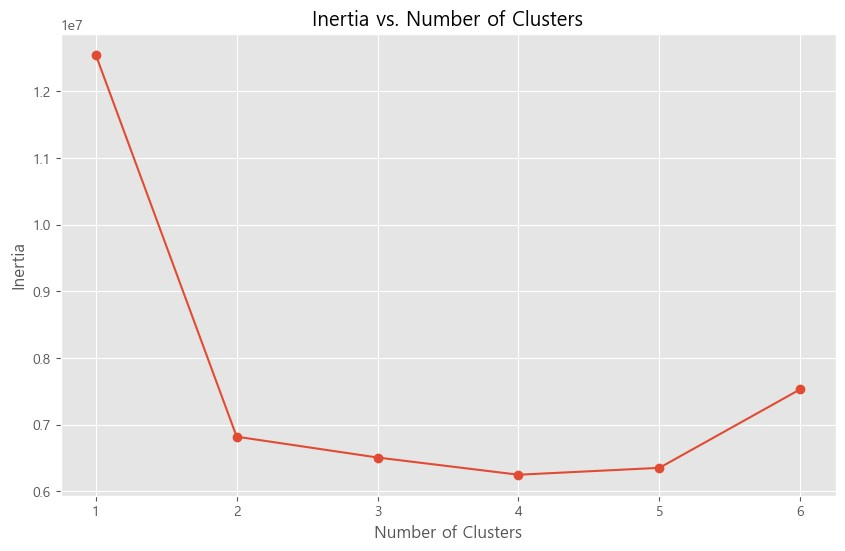

In [ ]:
# 시계열 클러스터링 진행
df_cut_T = df_cut.T
df_cut_T_array = df_cut_T.values
km = TimeSeriesKMeans(n_clusters=4, verbose=False, random_state=42, n_jobs=-1, metric='dtw')
y_pred = km.fit_predict(df_cut_T_array)

In [ ]:
df_cut_T['label'] = y_pred
df_cut_T

In [ ]:
df_TSK_0 = df_cut_T[df_cut_T['label'] == 0]
df_TSK_1 = df_cut_T[df_cut_T['label'] == 1]
df_TSK_2 = df_cut_T[df_cut_T['label'] == 2]
df_TSK_3 = df_cut_T[df_cut_T['label'] == 3]

In [ ]:
df_0 = df_TSK_0.T
df_0.drop('label', axis=0, inplace=True)
df_1 = df_TSK_1.T
df_1.drop('label', axis=0, inplace=True)
df_2 = df_TSK_2.T
df_2.drop('label', axis=0, inplace=True)
df_3 = df_TSK_3.T
df_3.drop('label', axis=0, inplace=True)
# df_4 = df_TSK_3.T
# df_4.drop('label', axis=0, inplace=True)
# df_5 = df_TSK_3.T
# df_5.drop('label', axis=0, inplace=True)
# df_6 = df_TSK_3.T
# df_6.drop('label', axis=0, inplace=True)
# df_7 = df_TSK_3.T
# df_7.drop('label', axis=0, inplace=True)
# df_8 = df_TSK_3.T
# df_8.drop('label', axis=0, inplace=True)
# df_9 = df_TSK_3.T
# df_9.drop('label', axis=0, inplace=True)

In [ ]:
df_0

- KLD 활용해볼것

##### 군집별 시각화 자료 (변수 별로 추이를 월, 연도에 따라 나타냄)

In [ ]:
cluster_lst = [df_0, df_1, df_2, df_3]

In [ ]:
def monthly_visualization(df):
    df.index = pd.to_datetime(df.index)
    df['월'] = df.index.to_period('M')
    
    df_monthly = df.groupby('월').sum()
    df_monthly.index = df_monthly.index.strftime('%Y-%m').astype('object')

    plt.figure(figsize=(30, 10))
    for column in df_monthly.columns:
        plt.plot(df_monthly.index, df_monthly[column], marker='o', label=column)

    plt.title('같은 군집 내 변수 월별 추이')
    plt.xlabel("시간 단계")
    plt.ylabel("값")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def year_visualization(df):
    df.index = pd.to_datetime(df.index)
    df['연'] = df.index.to_period('Y')
    
    df_year = df.groupby('연').sum()
    df_year.index = df_year.index.strftime('%Y').astype('object')

    plt.figure(figsize=(30, 10))
    for column in df_year.columns:
        plt.plot(df_year.index, df_year[column], marker='o', label=column)

    plt.title('같은 군집 내 변수 연도별 추이')
    plt.xlabel("시간 단계")
    plt.ylabel("값")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
cluster_lst = [df_0, df_1, df_2, df_3]

In [ ]:
for df in cluster_lst:
    monthly_visualization(df)

In [ ]:
for df in cluster_lst:
    year_visualization(df)

##### 군집별 시각화 자료 2 (군집 별로 평균 추이를 월별로 나타냄)

In [ ]:
cluster_T_lst = [df_TSK_0, df_TSK_1, df_TSK_2, df_TSK_3]

In [ ]:
def montly_trend(df):
    for df in cluster_T_lst:
        plt.figure(figsize=(45, 10))
        df_mean = pd.DataFrame(df.mean())
        df_mean.drop('label', axis=0, inplace=True)
        df_mean.index = pd.to_datetime(df_mean.index)
        df_mean.columns = ['mean']
        df_mean['월'] = df_mean.index.to_period('M')

        df_monthly = df_mean.groupby('월').sum()
        df_monthly.index = df_monthly.index.strftime('%Y-%m').astype('object')
        df_monthly

    plt.rcParams['lines.antialiased'] = True
    plt.plot(df_monthly['mean'], linestyle='--', marker='o', color='grey', label='monthly trend')
    plt.xlabel('X 축')
    plt.ylabel('Y 축')
    plt.title('추세선')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
for df in cluster_T_lst:
    montly_trend(df)

In [ ]:
# data_frames_dict = {}
def montly_trend_sum(k):
    data_frames_dict = {}
    for i in range(k):
        df = cluster_T_lst[i]
        plt.figure(figsize=(45, 10))
        df_mean = pd.DataFrame(df.mean())
        df_mean.drop('label', axis=0, inplace=True)
        df_mean.index = pd.to_datetime(df_mean.index)
        df_mean.columns = ['mean']
        df_mean['월'] = df_mean.index.to_period('M')

        df_monthly = df_mean.groupby('월').sum()
        df_monthly.index = df_monthly.index.strftime('%Y-%m').astype('object')
        data_frames_dict[f'df_m{i}'] = df_monthly

    list_of_dataframes = [df for df in data_frames_dict.values()]
    combined_df = pd.concat(list_of_dataframes, axis=1)
    combined_df.columns = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3']

    plt.figure(figsize=(30, 10))
    for column in combined_df.columns:
        plt.plot(combined_df.index, combined_df[column], marker='o', label=column)

    plt.title('군집별 월별 추이 평균 그래프')
    plt.xlabel("시간 단계")
    plt.ylabel("값")
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
montly_trend_sum(4)

## 큰일 났다 추이가 보이지 않는다!

시계열 데이터에서 군집 분석을 수행하려면 몇 가지 접근 방법을 고려할 수 있습니다. 시계열 데이터의 특성을 고려하여 데이터 전처리 및 군집화 알고리즘 선택에 주의해야 합니다.

다음은 시계열 데이터에 대한 군집 분석을 수행하는 일반적인 단계와 고려사항입니다:

1. 데이터 전처리:
- 시계열 데이터의 경우 시간 간격, 빈 공간 처리 등에 주의해야 합니다. 데이터가 누락된 경우 보간(interpolation) 기법을 사용하여 누락 값을 대체할 수 있습니다.

2. 특성 추출:
- 시계열 데이터를 군집화하기 위해 적절한 특성을 추출해야 합니다. 주로 통계량 (예: 평균, 분산), 주파수 도메인 특성 (예: 주파수 분포) 등을 활용합니다.

3. 유사도/거리 측정:
- 군집 분석을 위해 적절한 유사도 또는 거리 측정 방법을 선택해야 합니다. 시계열 데이터의 경우 유클리디안 거리 외에도 동적 시간 왜곡(DTW) 등의 거리 측정 방법을 고려할 수 있습니다.

4. 군집 알고리즘 선택: 
- 시계열 데이터에 적합한 군집 알고리즘을 선택해야 합니다. K-means, 계층적 군집화, DBSCAN 등을 활용할 수 있습니다. 하지만 시계열 데이터의 특성을 고려하여 알고리즘을 선택하고 매개변수를 조정해야 합니다.

5. 군집화 평가:
- 군집화 결과를 평가하고 해석하는 것이 중요합니다. 실루엣 스코어, 엘보우 메서드, 시각화 등을 활용하여 군집화 품질을 평가할 수 있습니다.

6. 결과 해석:
- 군집화 결과를 시각화하고 해석하여 의미 있는 인사이트를 얻어내는 것이 중요합니다. 시계열 데이터의 경우 군집화된 그룹들 간의 시계열 패턴 비교 및 분석이 필요합니다.
시계열 데이터의 군집 분석은 데이터의 특성과 목표에 따라 다양한 방법을 활용할 수 있습니다. 이러한 단계와 고려사항을 기반으로 데이터를 탐색하고 의미 있는 군집 결과를 도출할 수 있을 것입니다.


PCA (Principal Component Analysis)는 주로 연속형 수치 데이터의 차원을 축소하는데 사용되며, 시계열 데이터에도 적용할 수 있습니다. 그러나 시계열 데이터의 경우 일부 추가 고려사항이 있습니다.

PCA를 시계열 데이터에 적용하기 전에 고려해야 할 사항은 다음과 같습니다:

1. 데이터 정규화: PCA는 변수 간 스케일 차이가 크게 영향을 미칠 수 있기 때문에 데이터를 정규화하는 것이 중요합니다. 특히 시계열 데이터에서는 시간에 따라 스케일이 변하는 경우가 많기 때문에 정규화 과정을 신중하게 수행해야 합니다.

2. 시간 구조: PCA는 변수 간의 선형 관계를 강조하기 때문에 시계열 데이터의 시간 구조를 무시할 수 있습니다. 시간적인 패턴과 상관관계를 유지하면서 차원 축소를 하려면 주성분 시간 의존성을 고려하는 다른 방법을 고려해야 할 수 있습니다.

3. 고차원 데이터: 시계열 데이터는 고차원일 수 있으며, PCA를 적용하면 계산 비용이 증가할 수 있습니다. 이에 대한 성능 및 계산 비용 고려가 필요합니다.

4. 해석 가능성: PCA는 변수들을 새로운 주성분 축으로 변환하는 것이기 때문에, 결과 해석이 어려울 수 있습니다. 시계열 데이터의 의미 있는 시간적인 변화나 패턴을 유지하며 축소할 수 있는 다른 방법을 고려할 수 있습니다.

시계열 데이터에 PCA를 적용하려면 위의 고려사항을 고려하여 데이터를 전처리하고, 데이터의 성격과 목표에 맞게 PCA를 수행하거나 다른 차원 축소 기법을 고려할 필요가 있습니다. 데이터의 특성과 분석 목적에 따라 적절한 방법을 선택하고 적용하는 것이 중요합니다.


시계열 데이터에서 PCA를 적용할 때 주의해야 할 "시간 구조"에 대해 좀 더 자세히 설명해 드리겠습니다.

PCA는 변수 간의 선형 관계를 찾아내는 차원 축소 기법으로, 주성분들을 찾아내어 데이터를 새로운 축으로 변환합니다. 하지만 시계열 데이터는 시간에 따라 변화하는 동적인 특성을 가지고 있어, 시간 구조를 무시하면 데이터의 중요한 정보가 손실될 수 있습니다.

예를 들어, 주식 가격 데이터나 기후 데이터와 같이 시간적인 변동이 중요한 경우를 생각해보겠습니다. 이러한 데이터에서 PCA를 단순히 적용하면 주성분들이 시간적인 패턴을 고려하지 않고 변수들 간의 변동성만을 고려할 수 있습니다. 결과적으로 PCA로 변환한 데이터는 시간적인 패턴을 잃어버릴 수 있습니다.

이러한 문제를 해결하려면 PCA 대신 시간 구조를 고려한 다른 차원 축소 기법을 고려할 수 있습니다. 몇 가지 대안적인 방법은 다음과 같습니다:

1. 시계열 특성을 추가: 시계열 데이터를 변환하기 전에, 원본 데이터에 시간적인 특성을 추가하여 시간 구조를 보존할 수 있습니다. 예를 들어, 시간 간격을 나타내는 열을 추가하거나, 주기성이 있는 데이터의 경우 주기성을 나타내는 열을 추가할 수 있습니다.

2. Dynamic Time Warping (DTW): DTW는 두 시계열 데이터 간의 유사성을 측정하는 방법으로, 시간적인 패턴을 고려하여 거리를 계산합니다. DTW를 사용하여 시계열 데이터를 비교하고, 이를 기반으로 차원 축소를 진행할 수 있습니다.

3. Time Series Embedding: 시계열을 저차원 공간에 임베딩하는 방법 중 하나로, 시간 구조를 보존하면서 차원 축소를 할 수 있습니다. 예를 들어, SAX (Symbolic Aggregate approXimation)와 같은 방법을 사용할 수 있습니다.

위의 방법 중 하나를 선택하여 시계열 데이터의 시간 구조를 고려한 차원 축소를 수행하면, 데이터의 시계열 패턴을 유지하면서도 차원을 축소할 수 있습니다.


주기성을 나타내는 열을 추가하는 방법은 시계열 데이터의 주기성을 고려하여 시간에 따른 패턴을 더 잘 나타낼 수 있도록 도와줍니다. 이를 통해 PCA나 다른 차원 축소 기법을 적용할 때 주기성을 보존하면서 차원을 축소할 수 있습니다. 주기성을 나타내는 열을 추가하는 몇 가지 방법은 다음과 같습니다:

1. 날짜와 시간 정보 활용: 날짜와 시간 정보를 추출하여 주기성을 나타내는 열을 추가할 수 있습니다. 예를 들어, 연도, 월, 일, 요일, 시간대 등의 정보를 추출하여 각각의 열로 추가할 수 있습니다. 이러한 열은 주기성을 나타내는 특성을 가질 수 있습니다.

2. 사인 및 코사인 변환: 사인(sin)과 코사인(cos) 함수는 주기성을 나타내는 데 유용하게 활용될 수 있습니다. 시간에 따른 사인 및 코사인 변화를 나타내는 열을 추가하여 주기성을 나타낼 수 있습니다. 이러한 변환은 주로 계절성이나 주기성이 있는 데이터에 유용합니다.

3. 푸리에 변환: 푸리에 변환은 시간 도메인의 시계열 데이터를 주파수 도메인으로 변환합니다. 주파수 도메인에서 주기성이 뚜렷하게 드러날 수 있으며, 푸리에 변환을 통해 주기성을 나타내는 열을 생성할 수 있습니다.

4. 라그 특성: 현재 시점의 값과 과거 시점의 값을 비교하여 변화를 나타내는 라그(lag) 특성을 추가할 수 있습니다. 이를 통해 주기성이나 계절성을 나타내는 열을 생성할 수 있습니다.

이러한 방법들을 활용하여 주기성을 나타내는 열을 추가하면, 시계열 데이터의 주기성을 보존하면서도 차원을 축소할 수 있습니다. 주기성을 나타내는 열을 추가할 때는 데이터의 특성과 분석 목적에 따라 적절한 방법을 선택하여 적용하면 됩니다.

분석 진행중..